<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение моделей</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговые выводы</a></span></li></ul></div>

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Прогнозирование заказов такси

## Описание проекта

**Заказчик** - компания «Чётенькое такси». Для привлечения большего числа водителей в периоды пиковой нагрузки, им необходима модель, способная прогнозировать количество заказов такси на следующий час. 

**Исходные данные** - исторические данные о заказах такси в аэропорт. 

Необходимо, чтобы значение метрики качества RMSE на тестовой выборке не превышало 48.

Исходные данные состоят из двух столбцов:
* datetime - дата и время заказа
* num_orders - количество заказов

## Описание данных

Начнем работу с загрузки данных. Не забудем заранее отметить первый столбец с временем и датой как способ индексации наблюдений - в рамках работы с временными рядами такой способ индексации значительно облегчает дальнейшую работу.

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

Выведем основную информацию об исходных данных. 

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Что можно сказать о полученных данных? Все наблюдения лежат во временном промежутке 2018 года с первого марта по конец августа. Каждое наблюдение отражает число заказов за последние 10 минут. Пропусков не наблюдается.

Поскольку строить прогноз для каждых 10 минут не только непросто, но и неоптимально, приведем данные к почасовому формату - просуммируем количество заказов, которые были совершены в течении каждого часа в рассматриваемый период.

In [5]:
df = df.resample('1H').sum()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Благодаря данному преобразованию нам удалось сократить исходную выборку в несколько раз, при этом не потеряв информативность данных. 

Визуально оценим данные по числу заказов в рассматриваемый период.

In [6]:
font = {'family': 'serif','weight': 'normal', 'size': 20}

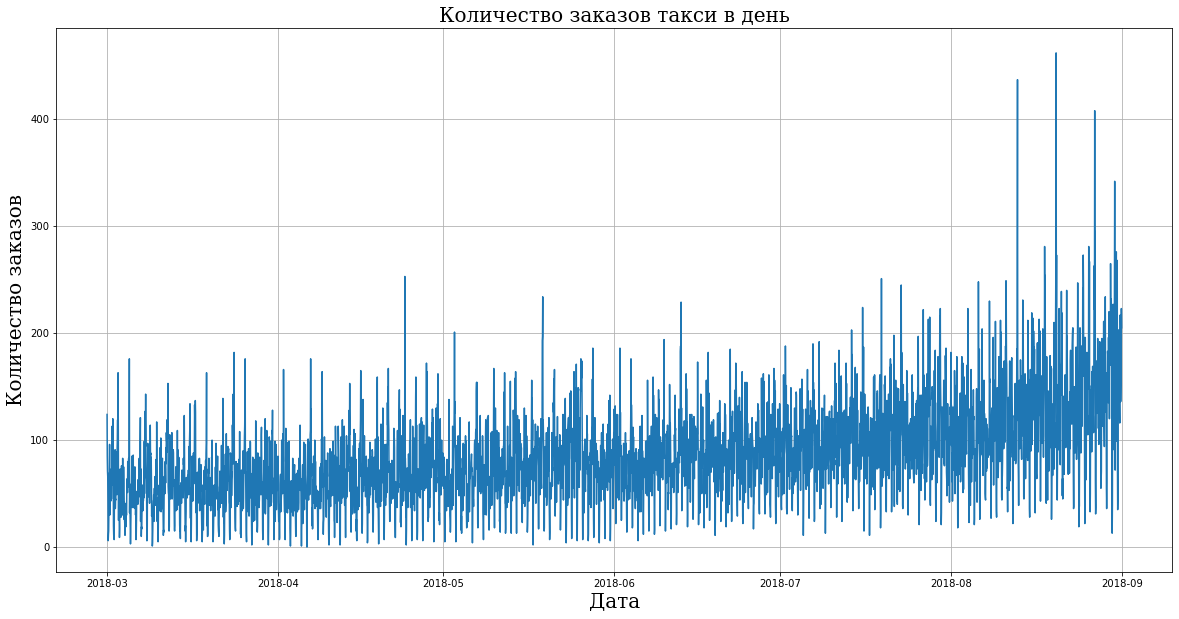

In [7]:
plt.figure(figsize=[20, 10])
plt.plot(df)
plt.title('Количество заказов такси в день', fontdict=font)
plt.xlabel('Дата', fontdict=font)
plt.ylabel('Количество заказов', fontdict=font)
plt.grid(True)
plt.show()

На графике просматривается восходящий тренд в данных - среднее число заказов увеличивается к окончанию рассматриваемого периода. В то же время не наблюдается четкая сезонность, однако для более точного заключения взглянем на график заказов в течении одного дня.

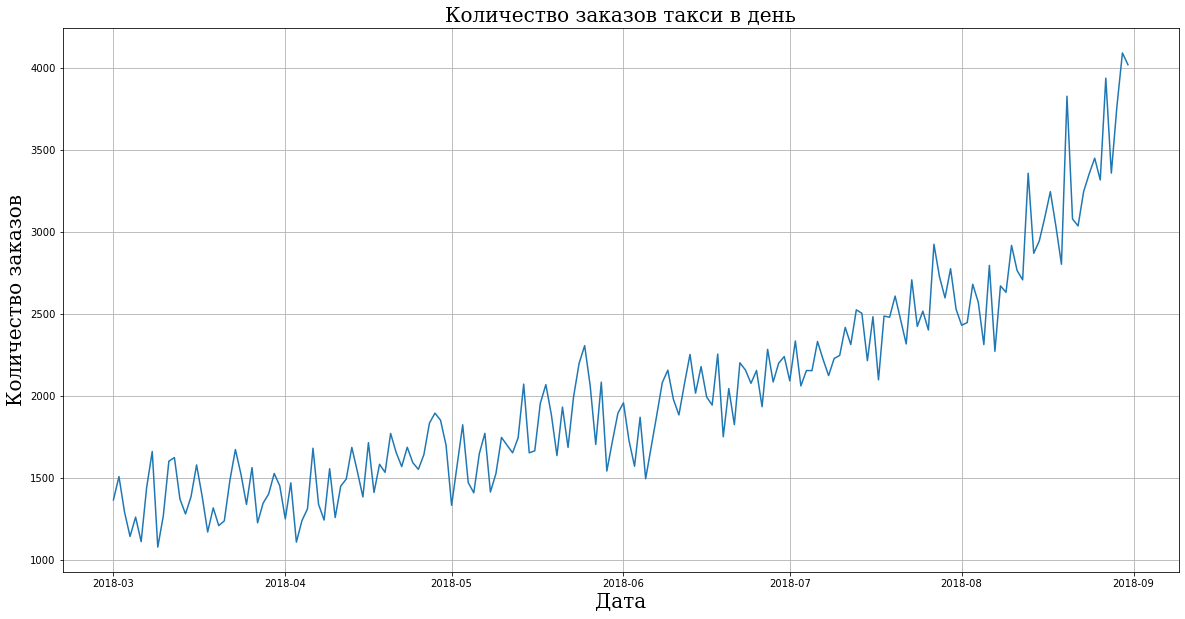

In [8]:
plt.figure(figsize=[20, 10])
plt.plot(df.resample('D').sum())
plt.title('Количество заказов такси в день', fontdict=font)
plt.xlabel('Дата', fontdict=font)
plt.ylabel('Количество заказов', fontdict=font)
plt.grid(True)
plt.show()

Как и до этого, ярко прослеживается восходящий тренд. Ярко выраженной сезонности не обнаружено.

Дополнительно выведем графики тренда, сезонности и остатков ряда в отдельности.

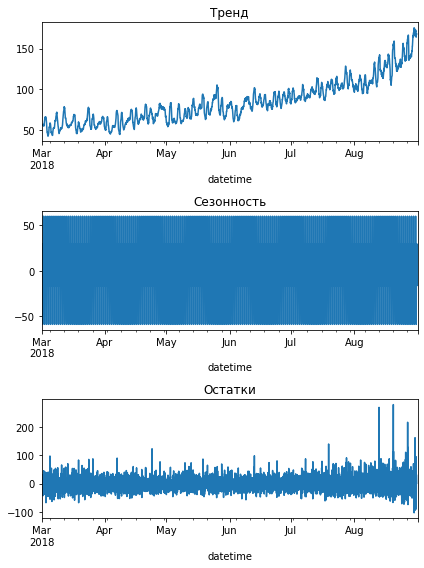

In [9]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()

Вновь подтвердился восходящий тренд. Остатки ряда можно считать стационарными.

Теперь для более детального анализа сезонности рассмотрим декомпозицию на трех более коротких интервалах.

Text(0.5, 1.0, 'Сезонность в период 2018-08-26:2018-08-31')

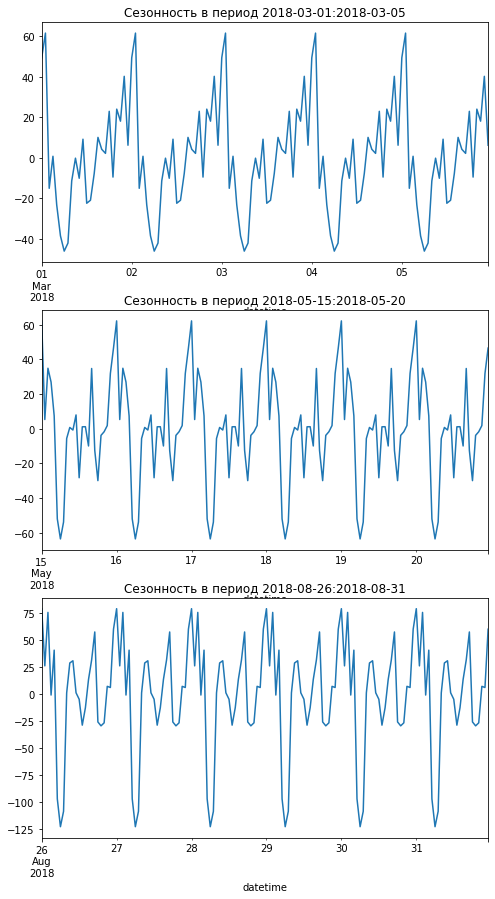

In [10]:
decomposed_1 = seasonal_decompose(df['2018-03-01':'2018-03-05'])
decomposed_2 = seasonal_decompose(df['2018-05-15':'2018-05-20'])
decomposed_3 = seasonal_decompose(df['2018-08-26':'2018-08-31'])

plt.figure(figsize=(8,15))
plt.subplot(3,1,1)
decomposed_1.seasonal.plot(ax=plt.gca())
plt.title('Сезонность в период 2018-03-01:2018-03-05')

plt.subplot(3,1,2)
decomposed_2.seasonal.plot(ax=plt.gca())
plt.title('Сезонность в период 2018-05-15:2018-05-20')

plt.subplot(3,1,3)
decomposed_3.seasonal.plot(ax=plt.gca())
plt.title('Сезонность в период 2018-08-26:2018-08-31')

 На трех полученных графиках сезонности можно заметить некоторую обобщенную цикличность - вначале дн идет резкое сокращение числа заказов, а к концу дня число заказов, напротив, увеличивается.

## Построение моделей

Перейдем к этапу моделирования. Для построения прогноза мы будем рассматривать две модели: модель линейной регрессии и LGBM регрессию. Однако перед тем как перейти к этапу моделирования займемся созданием дополнительных признаков, которые будет использовать модели. 

Напишем функцию, которая будет создавать дополнительные признаки:
* добавлять месяц, день и день недели
* добавлять некоторое число лагов таргета
* добавлять величину скользящего среднего некоторой кратности

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Теперь напишем функцию, которая будет подбирать оптимальные параметры для количества лагов и кратности скользящего среднего минимизируя значение критерия качества RMSE. 

На вход функция будет получать название модели, которая будет обучаться, данные для обучения, максимальное и минимальное допустимое число лагов, а также минимальную и максимальную кратность для скользящего среднего.

In [12]:
def params_selections(model, data, lag_min, lag_max, roll_min, roll_max):
    lag = 0
    roll = 0
    rmse_min = 48
    for roll_numb in range(roll_min, roll_max):
        
        for lag_numb in range(lag_min, lag_max):
            data_new = data.copy()
            make_features(data_new, lag_numb, roll_numb)
            
            train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
            train = train.dropna()
            test = test.dropna()
            features_test = test.copy().drop(['num_orders'], axis=1)
            target_test = test['num_orders'].copy()
            
            tscv = TimeSeriesSplit(n_splits = 5)
            
            rmse = []
            for train_index, valid_index in tscv.split(train):
                cv_train, cv_valid = train.iloc[train_index], train.iloc[valid_index]
                train_f = cv_train.drop(['num_orders'], axis=1)
                train_t = cv_train['num_orders']
    
                mod = model.fit(train_f, train_t)
    
                predictions = mod.predict(cv_valid.drop(['num_orders'], axis=1))
                true_values = cv_valid['num_orders']
                rmse.append((mean_squared_error(true_values, predictions, squared = False)))
                
            final_rmse = np.mean(rmse)
            
            if final_rmse < rmse_min:
                lag = lag_numb
                rmse_min = final_rmse
                roll = roll_numb
                
    make_features(data, lag, roll)
    
    train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
    train = train.dropna()
    test = test.dropna()
    
    features_train = train.copy().drop(['num_orders'], axis=1)
    target_train = train['num_orders'].copy()
    features_test = test.copy().drop(['num_orders'], axis=1)
    target_test = test['num_orders'].copy()
    
    model = model.fit(features_train, target_train)
    prediction = model.predict(features_test)
    prediction = pd.DataFrame(data=prediction, index = target_test.index)
    
    print('Количество лагов временного ряда:', lag)
    print('Число разностей временного ряда:', roll)
    print("RMSE обучающей выборки:", final_rmse)
    print("RMSE тестовой выборки: ", mean_squared_error(target_test, prediction, squared = False))
    
    plt.figure(figsize=(15,10))
    plt.plot(target_train['2018-08-01':'2018-08-31'])
    plt.plot(target_test)
    plt.plot(prediction)
    plt.legend(['train[num_orders]', 'target_test', 'prediction'], loc='upper left')
    plt.show()
    return

Передадим функции требуемые параметры. Для начала попробуем спрогнозировать параметры для модели линейной регрессии.

Количество лагов временного ряда: 99
Число разностей временного ряда: 12
RMSE обучающей выборки: 24.17812886066796
RMSE тестовой выборки:  41.454262079019166


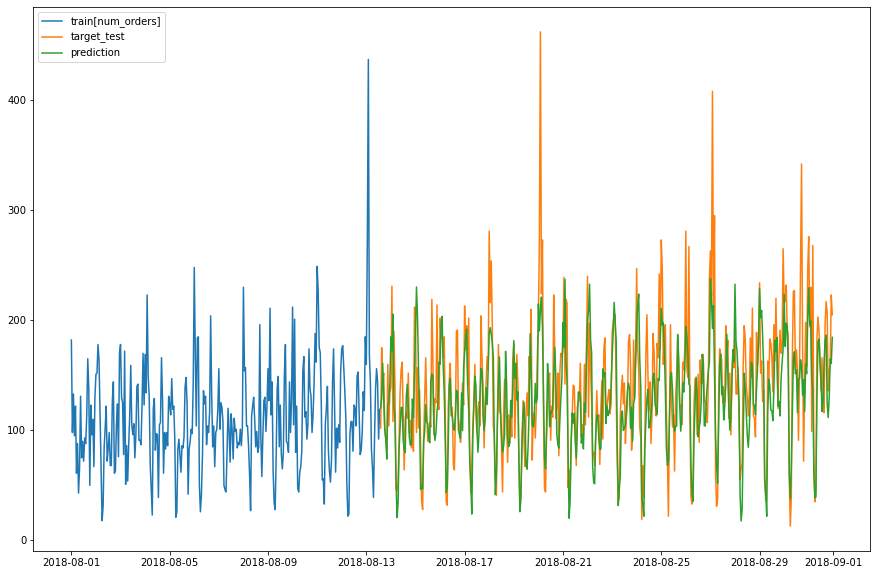

In [13]:
params_selections(LinearRegression(),df,1,100,1,20)

Мы подобрали наиболее оптимальные параметры для создания переменных таким образом, чтобы минимизировать критерий качества RMSE на тренировочных данных. При этом значение RMSE на тренировочных данных ниже необходимого порога от заказчика. 

Вместе с тем мы можем сделать вывод, что полученная нами модель линейной регрессии значительно переобучилась на тренировочных данных - показатель RMSE на тестовых данных вырос почти в два раза по сравнению с аналогичным показателем на тренировочных данных. 

Повторим процедуру подбора оптимальных параметров для модели LGBM.

Количество лагов временного ряда: 1
Число разностей временного ряда: 4
RMSE обучающей выборки: 25.253109375905147
RMSE тестовой выборки:  42.74897963285901


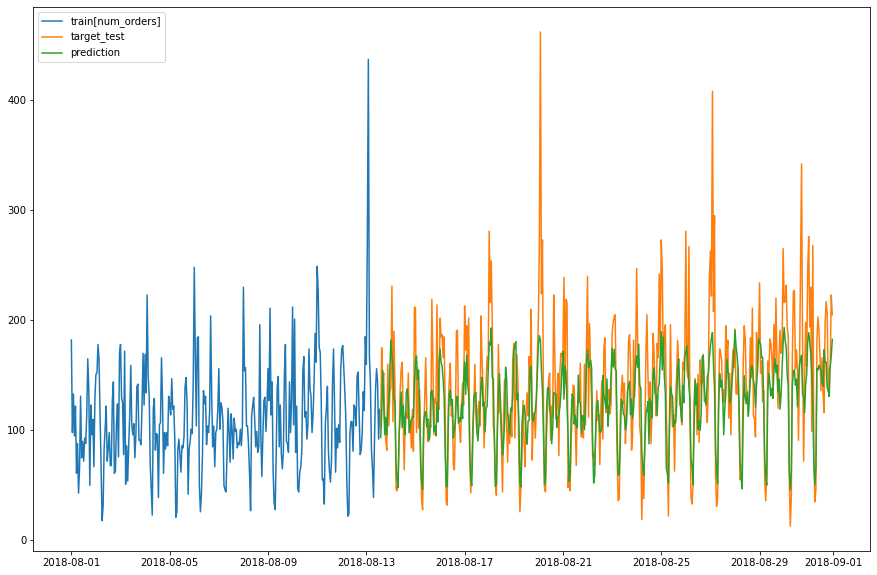

In [18]:
params_selections(LGBMRegressor(random_state=9, n_jobs=-1, n_estimators=20),df,1,80,1,10)

Полученная нами модель LGBM регрессии по результатам показала себя несколько хуже обычной линейной регрессии. Между тем, в ней также присутствует переобучение - разница между тренировочным качеством и аналогичным показателем на тестовых данных почти в два раза.

По итогу нами принято решение выбрать модель линейной регрессии в качестве итоговой.

## Итоговые выводы

Перед нами стояла задача построения модели для прогнозирования числа заказов такси в ближайший час. В качестве основной модели мы выбрали линейную регрессию. Также мы создали функцию, которая будет подбирать наиболее оптимальные значения для создания дополнительных переменных. Подбор осуществлялся на основании минимизации критерия качества RMSE. Мы построили две модели: линейную регрессию и LGBM регрессию. По итогу на основании качества модели была выбрана модель линейной регрессии.

Полученная нами итоговая модель с дополнительными переменными имела неплохое качество критерия RMSE на тренировочных данных, а также удовлетворяла порогу качества на тестовых данных. Между тем, мы обнаружили, что полученная нами модель довольно сильно переобучилась - качество на тренировочных данных почти в два раза меньше аналогичного показателя на тестовых данных.